# Searching For (Sub-)Structure in Disks

There is a wealth of information that is hidden in the line emission. While `GoFish` is useful for teasing our low level emission from noisy data, we can also harness the velocity structure to tease out subtle deivations in the background physical or dynamical structure.

This notebook will guide you through a few ways you can explore the data a little futher. It'll use the 12CO data presented in [Huang et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...852..122H/abstract) which is available from [the Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PXDKBC). To run this Notebook, this cube will be in the working directory.

## Collapsing to Moment Maps

As mentioned in other Notebooks, working with a collapsed, 2D moment map is much easier than working with the full 3D data. To start, we use [`bettermoments`](https://github.com/richteague/bettermoments) to make a peak brightness temperature map.

In [1]:
!bettermoments dataverse_TWHya_CO_cube.fits

Loading up data...
Estimated RMS: 1.91e-03.
Calculating maps...
Saving maps...


The default method for `bettermoments` is the `quadratic` method which returns both maps of the line center, `*_v0.fits`, and the line peak, `*_Fnu.fits`. There are many other ways to collapse your data which is covered in the [`bettermoments` documenation](https://bettermoments.readthedocs.io/).

## Inspecting the Data

For this section, we'll work with just the peak flux density map. If you want to learn more about the line center, look at [`eddy`](https://eddy.readthedocs.io/en/latest/).

The first port of call is to inspect the data, so let's load it up.

In [1]:
import matplotlib.pyplot as plt
from gofish import imagecube
import numpy as np

In [3]:
cube = imagecube('dataverse_TWHya_CO_cube_Fnu.fits', FOV=10.0)

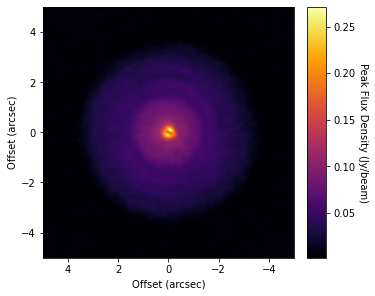

In [36]:
fig, ax = plt.subplots(constrained_layout=True)
im = ax.imshow(cube.data, origin='lower', extent=cube.extent, cmap='inferno')
cb = plt.colorbar(im, pad=0.02, ticks=np.arange(0, 0.3, 0.05))
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Peak Flux Density (Jy/beam)', rotation=270, labelpad=13)

In [4]:
x, y, dy = cube.radial_profile(inc=5.0, PA=151.0)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Text(0, 0.5, 'Peak Flux Density (Jy/beam)')

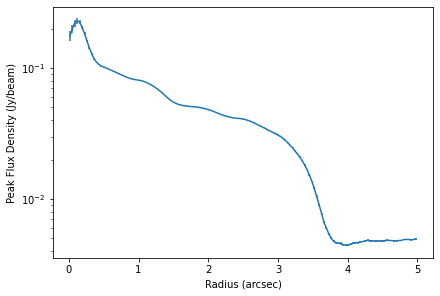

In [7]:
fig, ax = plt.subplots(constrained_layout=True)
ax.errorbar(x, y, dy)
ax.set_yscale('log')
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Peak Flux Density (Jy/beam)')

You can clearly see bumps and wiggles associated with the gaps and rings in the system.

## Localized Deviations

One of the most exciting ideas for causing gaps and rings are embedded planets. [Cleeves et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...807....2C/abstract) suggested that a way to find these features is to subtract a mean background to reveal localized enhancements in emission which can be associated with embedded planets.

To do this, we can use the `background_residual` function. In brief, this function makes an azimuthally averaged radial profile of the data (as we have done above), then projects it onto the sky to make a mean background model which is subtracted from the data.

In [8]:
residual = cube.background_residual(inc=5.0, PA=151.0)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


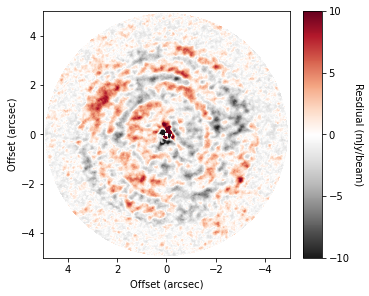

In [24]:
fig, ax = plt.subplots(constrained_layout=True)
im = ax.imshow(residual * 1e3, origin='lower', extent=cube.extent, cmap='RdGy_r', vmin=-10, vmax=10)
cb = plt.colorbar(im, pad=0.02, ticks=np.arange(-10, 15, 5))
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Resdiual (mJy/beam)', rotation=270, labelpad=13)

While we haven't uncovered little point sources, we have found large spiral structure, which are described in more detail in [Teague et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019ApJ...884L..56T/abstract).

Regions outside the interpolation range are set to `np.nan`, however this can be changed with the inclusion of `interp1d_kw=dict(fill_value=0.0)` which will set all filled values to 0 (or any value you wish).

Sometimes it's also useful to visualize the background model too. This can be done by setting `background_only=True` in the call to `background_residual`, as so:

In [25]:
background = cube.background_residual(inc=5.0, PA=151.0, background_only=True)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


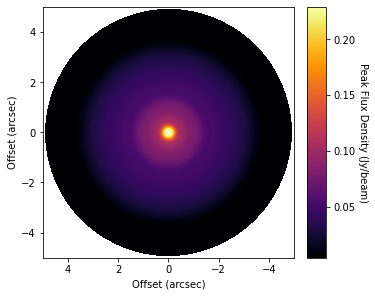

In [37]:
fig, ax = plt.subplots(constrained_layout=True)
im = ax.imshow(background, origin='lower', extent=cube.extent, cmap='inferno')
cb = plt.colorbar(im, pad=0.02, ticks=np.arange(0, 0.3, 0.05))
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Peak Flux Density (Jy/beam)', rotation=270, labelpad=13)

Note that while we used the peak flux density as the moment map to explore, [Cleeves et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...807....2C/abstract)) advocated for the use of the zeroth moment (total intensity) instead. This method can be used for any form of moment map assuming that the background is assumed to be azimuthally symmetric (unlike rotation maps, for example).

Note that you can also include the standard `GoFish` masking properties for defining the region you wish to use to make your background model. For example, only the red-shifted side of the disk:

In [46]:
residual_mask = cube.background_residual(inc=5.0, PA=151.0, PA_min=-90.0, PA_max=90.0)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


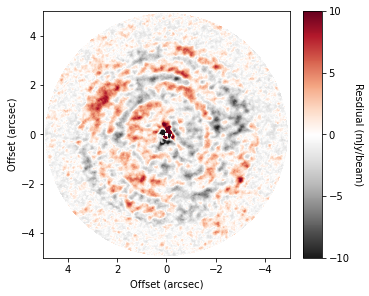

In [47]:
fig, ax = plt.subplots(constrained_layout=True)
im = ax.imshow(residual * 1e3, origin='lower', extent=cube.extent, cmap='RdGy_r', vmin=-10, vmax=10)
cb = plt.colorbar(im, pad=0.02, ticks=np.arange(-10, 15, 5))
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Resdiual (mJy/beam)', rotation=270, labelpad=13)

However, for the broadly azimuthally symmetric TW Hya, this doesn't make a noticable difference.

## Rotation Profiles

We can also use the full data cube to infer a radial velocity profile following the method in [Teague et al. (2018a)](https://ui.adsabs.harvard.edu/abs/2018ApJ...860L..12T/abstract), [Teague et al. (2018b)](https://ui.adsabs.harvard.edu/abs/2018ApJ...868..113T/abstract) and extended to 3D velocities in [Teague et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019Natur.574..378T/abstract).

For this we need the whole data cube and not just the moment map. 

In [2]:
cube = imagecube('dataverse_TWHya_CO_cube.fits', FOV=6.0)

In brief, the `get_vlos` function will split the data into concentric annuli based on the geometrical properties provided. Then, for each annulus a random selection of pixels will be chosen and a rotation velocity (in addition to a radial velocity if `fit_vrad=True` is used) which best accounts for the azimuthally varying line center.

While not required, it is useful to provide a dynamical mass, `mstar`, and source distance, `dist`, such that the optimization routines have a good atarting position.

Here's we're just measuring the profile between 1 and 1.5 arcseconds for a demonstration. Without any specific `rbins` or `rvals` provided, it defaults to the `GoFish` standard of one quarter beam spacing. A lot of the heavy lifting is done in the `annulus` class, specifically the `annulus.get_vlos` function. Kwargs can be passed directly to this function through the `get_vlos_kwargs` argument, allowing for changes to be made to the number of walkers or steps taken for the MCMC analysis of the posterior distributions.

The `percentiles` array will have a shape of `(n_radii, n_params, 3)`, where there last axis is the 16th, 50th and 84th percentile of the posterior distribution.

In [12]:
rvals, percentiles = cube.get_vlos(inc=5.0, PA=151.0, mstar=0.8, dist=60.1, r_min=1.0, r_max=1.5,
                                   fit_vrad=True, get_vlos_kwargs=dict(nwalkers=64))

100%|██████████| 1000/1000 [00:45<00:00, 21.92it/s]


Text(0, 0.5, 'Radial Velocity (m/s)')

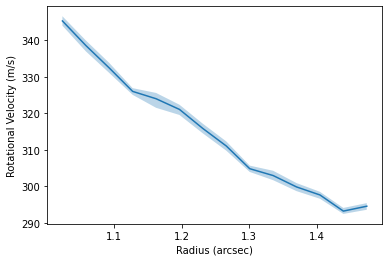

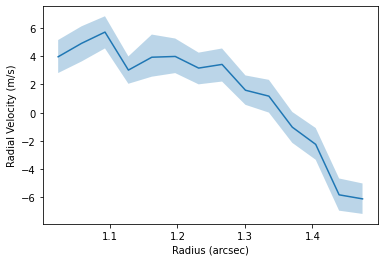

In [20]:
fig, ax = plt.subplots()
ax.fill_between(rvals, percentiles[:, 0, 0], percentiles[:, 0, 2], alpha=0.3)
ax.plot(rvals, percentiles[:, 0, 1])
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Rotational Velocity (m/s)')

fig, ax = plt.subplots()
ax.fill_between(rvals, percentiles[:, 1, 0], percentiles[:, 1, 2], alpha=0.3)
ax.plot(rvals, percentiles[:, 1, 1])
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Radial Velocity (m/s)')